In [61]:
from IPython.display import display, Image
import PIL.Image
import time
import torch
from torchvision import models, transforms
import matplotlib.pyplot as plt
from PIL import Image as PIMAGE
import math
import requests
from io import StringIO,BytesIO

In [11]:
def load_model(model_path):
    checkpoint = torch.load(model_path, 'cpu')

    model = models.vgg16(pretrained = False)
    model.classifier = checkpoint['classifier']
    optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.00001)

    model.load_state_dict(checkpoint['model_state'])
    idx_to_class = checkpoint['idx_to_class']

    return model,optimizer, idx_to_class

model_path = '/kaggle/input/vgg_islfingerspell/pytorch/91_acc_vgg/1/model_1.pth';
model, _, idx_to_class = load_model(model_path)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [65]:
http =  urllib3.PoolManager()

def process(image_path):
    image = None
    try:
        res = requests.get(image_path)
        byte_data = res.content
        image_byte = BytesIO(byte_data)
        image = PIMAGE.open(image_byte)
        
    except:
        image = PIMAGE.open(image_path)
    
    finally:
        mean = [0.6507, 0.5438, 0.5606]
        std = [0.1279, 0.1370, 0.1281]

        transform = transforms.Compose([
                        transforms.Grayscale(3),
                        transforms.Resize(150),
                        transforms.RandomCrop(128),
                        transforms.ToTensor(),
                        transforms.Normalize(mean, std)
                    ])


        image_tensor = transform(image)
        plt.imshow(image_tensor.permute(1,2,0).numpy())
        return image_tensor
    # print(image_tensor)

In [71]:
def predict_1(model, single_image):
    image = torch.zeros(size=(32,3,128,128))

#     for i in range(32):
#         image[i] = single_image
    image = single_image.unsqueeze(dim = 0)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    image, model = image.to(device), model.to(device)
    
    with torch.no_grad():
        model.eval()
        logp = model.forward(image)
        
    probs = torch.exp(logp)
    pred_prob, pred_class  = probs.topk(3, dim=1)
    return pred_prob[0].tolist(), pred_class[0].tolist()

G with probability 1.0
C with probability 0.0
O with probability 0.0


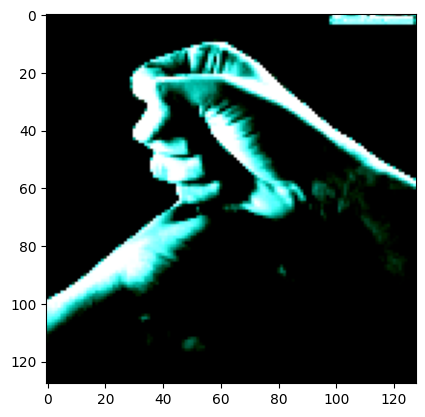

In [72]:
image_tensor = process('http://indiandeaf.org/images/ISL/isl-Alphabet-G.jpg')
pred_prob, y = predict_1(model, image_tensor)
for prob, y1 in zip(pred_prob, y):
    print(f'{idx_to_class[y1]} with probability {round(prob, 2)}')